<a href="https://colab.research.google.com/github/asundar0128/DroneDetectionUAV-AbhinitSundar-Detection/blob/main/dronedetectionuav_abhinitsundar_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install filterpy

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from filterpy.kalman import KalmanFilter

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
droneNetValue = cv2.dnn.readNet('/content/gdrive/MyDrive/yolov3.weights', '/content/gdrive/MyDrive/yolov3.cfg')

In [ ]:
droneLayerValue = droneNetValue.getUnconnectedOutLayersNames()

In [ ]:
droneKalmanFilterValue = KalmanFilter(dim_x = 4, dim_z = 2)
droneKalmanFilterValue.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
droneKalmanFilterValue.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

droneKalmanFilterValue.P *= 1e3
droneKalmanFilterValue.R = 5

In [ ]:
droneKalmanFilterTrajectoryPoints = []

In [ ]:
def droneKalmanFilterUpdate(droneKalmanFilterValue, droneMeasurementValue):
  droneKalmanFilterValue.predict()
  droneKalmanFilterValue.update(droneMeasurementValue)

In [ ]:
def droneKalmanFilterDrawBoundingBox(droneKalmanFilterFrame):
  global droneKalmanFilterTrajectoryPoints
  droneKalmanFilterHeight, droneKalmanFilterWidth, _ = droneKalmanFilterFrame.shape

  droneKalmanFilterBlob = cv2.dnn.blobFromImage(droneKalmanFilterFrame, 1/255.0, (416, 416), swapRB = True, crop = False)
  droneNetValue.setInput(droneKalmanFilterBlob)
  droneKalmanFilterOutput = droneNetValue.forward(droneLayerValue)

  droneKalmanFilterClassValue = []
  droneKalmanFilterConfidenceValues = []
  droneKalmanFilterBoundingBoxes = []

  for droneKalmanOutputValue in droneKalmanFilterOutput:
    for droneKalmanDetectionValue in droneKalmanOutputValue:
      droneKalmanFilterScoreValue = droneKalmanDetectionValue[5:]
      droneKalmanClassIdentifier = np.argmax(droneKalmanFilterScoreValue)
      droneKalmanFilterConfidenceValue = droneKalmanFilterScoreValue[droneKalmanClassIdentifier]
      if droneKalmanFilterConfidenceValue > 0.5:
        midXValueDroneKalman = int(droneKalmanDetectionValue[0] * droneKalmanFilterWidth)
        midYValueDroneKalman = int(droneKalmanDetectionValue[1] * droneKalmanFilterHeight)
        droneTrackingWidthValue = int(droneKalmanDetectionValue[2] * droneKalmanFilterWidth)
        droneTrackingHeightValue = int(droneKalmanDetectionValue[3] * droneKalmanFilterHeight)
        droneTrackingXCoordinate = int(midXValueDroneKalman - droneTrackingWidthValue / 2)
        droneTrackingYCoordinate = int(midYValueDroneKalman - droneTrackingHeightValue / 2)
        droneKalmanFilterClassValue.append(droneKalmanClassIdentifier)

        droneKalmanFilterConfidenceValues.append(float(droneKalmanFilterConfidenceValue))
        droneKalmanFilterBoundingBoxes.append([droneTrackingXCoordinate, droneTrackingYCoordinate, droneTrackingWidthValue, droneTrackingHeightValue])

        kalmanFilterIndexValues = cv2.dnn.NMSBoxes(droneKalmanFilterBoundingBoxes, droneKalmanFilterConfidenceValues, 0.6, 0.3)

        if kalmanFilterIndexValues is not None and len(kalmanFilterIndexValues) > 0:
          for a in kalmanFilterIndexValues.flatten():
           droneKalmanFilterBoundingBox = droneKalmanFilterBoundingBoxes[a]
           droneTrackingXCoordinate, droneTrackingYCoordinate, droneTrackingWidthValue, droneTrackingHeightValue = droneKalmanFilterBoundingBox

           cv2.rectangle(droneKalmanFilterFrame, (droneTrackingXCoordinate, droneTrackingYCoordinate), (droneTrackingXCoordinate + droneTrackingWidthValue, droneTrackingYCoordinate + droneTrackingHeightValue), (0, 255, 0), 2)

           droneMeasurementValue = np.array([[droneTrackingXCoordinate + droneTrackingWidthValue / 2], [droneTrackingYCoordinate + droneTrackingHeightValue / 2]])

           droneKalmanFilterUpdate(droneKalmanFilterValue, droneMeasurementValue)

           droneKalmanPredictedPosition = droneKalmanFilterValue.x[:2].astype(int)

           cv2.circle(droneKalmanFilterFrame, (int(droneKalmanPredictedPosition[0]), int(droneKalmanPredictedPosition[1])), 5, (0, 0, 255), -1)

           droneKalmanFilterTrajectoryPoints.append((int(droneKalmanPredictedPosition[0]), int(droneKalmanPredictedPosition[1])))

           return droneKalmanFilterFrame



In [ ]:
def droneKalmanFilterDrawingPath(droneKalmanFilterFrame):
    global droneKalmanFilterTrajectoryPoints
    for a in range(1, len(droneKalmanFilterTrajectoryPoints)):
      cv2.line(droneKalmanFilterFrame, droneKalmanFilterTrajectoryPoints[a - 1], droneKalmanFilterTrajectoryPoints[a], (255, 0, 0), 2)

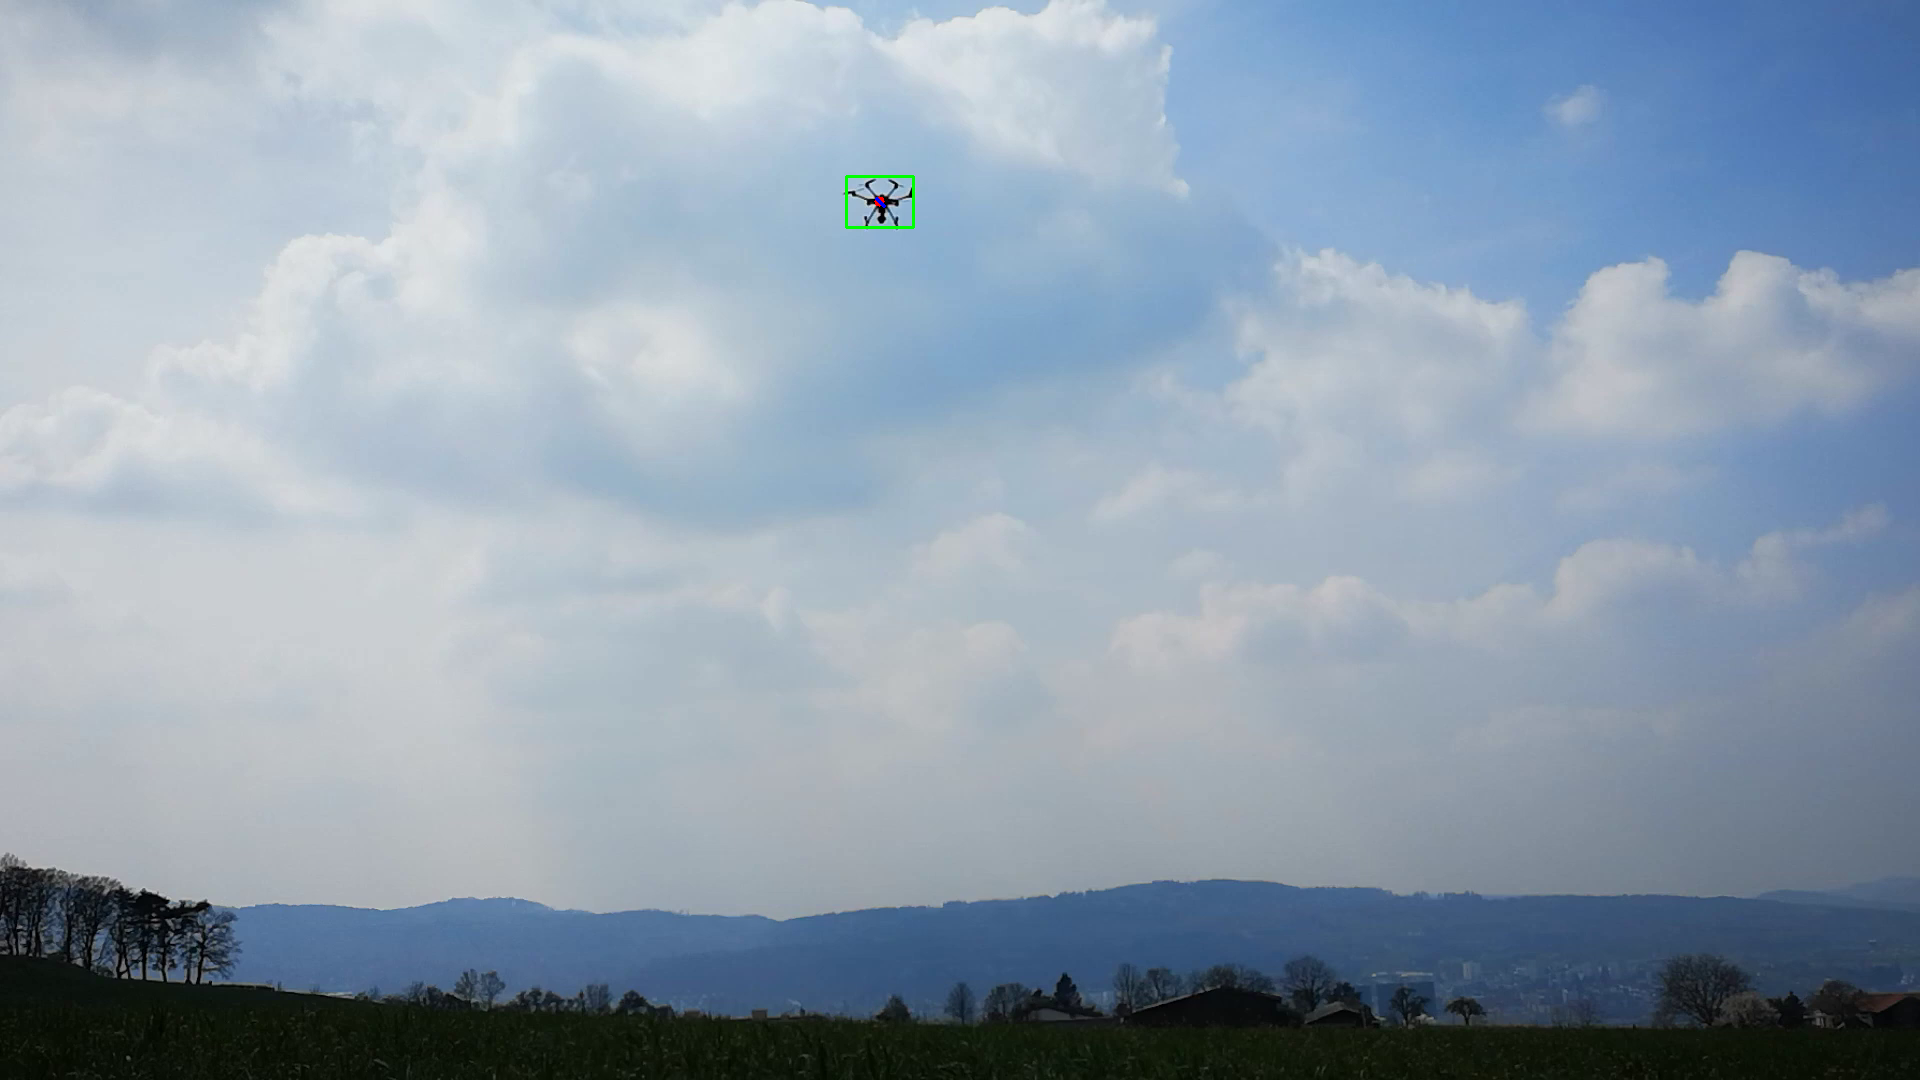

In [ ]:
from google.colab.patches import cv2_imshow
def droneKalmanVideoEvaluation(droneKalmanInputFileValue, droneKalmanOutputFileValue):
  global droneKalmanFilterTrajectoryPoints
  droneKalmanCapturedValue = cv2.VideoCapture(droneKalmanInputFileValue)
  droneKalmanVideoWritingValue = cv2.VideoWriter_fourcc(*'mp4v')
  droneKalmanOutputValue = cv2.VideoWriter(droneKalmanOutputFileValue, droneKalmanVideoWritingValue, 20.0, (int(droneKalmanCapturedValue.get(3)), int(droneKalmanCapturedValue.get(4))))

  while droneKalmanCapturedValue.isOpened():
    droneKalmanFilterRectangularBox, droneKalmanFilterFrame = droneKalmanCapturedValue.read()
    if not droneKalmanFilterRectangularBox:
      break

    evaluatedFrameDroneKalman = droneKalmanFilterDrawBoundingBox(droneKalmanFilterFrame)

    droneKalmanFilterDrawingPath(evaluatedFrameDroneKalman)

    cv2_imshow(evaluatedFrameDroneKalman)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    droneKalmanCapturedValue.release()
    droneKalmanOutputValue.release()

    droneKalmanOutputValue.write(evaluatedFrameDroneKalman)

droneFirstVideoValue = "/content/gdrive/MyDrive/DroneDetection/Drone Tracking 1.mp4"
droneSecondVideoValue = "/content/gdrive/MyDrive/DroneDetection/Drone Tracking 2.mp4"
droneKalmanVideoEvaluation(droneFirstVideoValue, droneSecondVideoValue)